In [1]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl pandas matplotlib jupyterlab pyarrow numpy scipy statsmodels tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
## getting the imports out of the way
import pandas as pd
idx = pd.IndexSlice
import numpy as np
import matplotlib.pyplot as plt



In [3]:
experiments_and_query_lengths = {
    "404265": "2_min",
    "404240": "10_min",
    "404266": "20_min",
}

In [4]:
# load all the parquet files
experiment_dfs = {}
for k,v in experiments_and_query_lengths.items():
    experiment_dfs[v] = pd.read_parquet(f"./parquets/{k}.parquet")

In [5]:
lel = experiment_dfs["2_min"].groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
((lel.last()-lel.first())[idx[:,:,"send"]] / np.timedelta64(1, "ms")).describe()

count      247.000000
mean      2309.192810
std       2515.877233
min          0.000000
25%          1.159500
50%       4053.119000
75%       4055.072000
max      10186.655000
Name: timestamp, dtype: float64

In [6]:
# lets prepare some data for plotting
data = []
averages = []
labels = []
for k,v in experiment_dfs.items():
    labels.append(k)
    group = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
    differences = (group.last() - group.first())[idx[:,:,"send"]] / np.timedelta64(1, "ms")
    averages.append(differences.mean())
    data.append(differences)

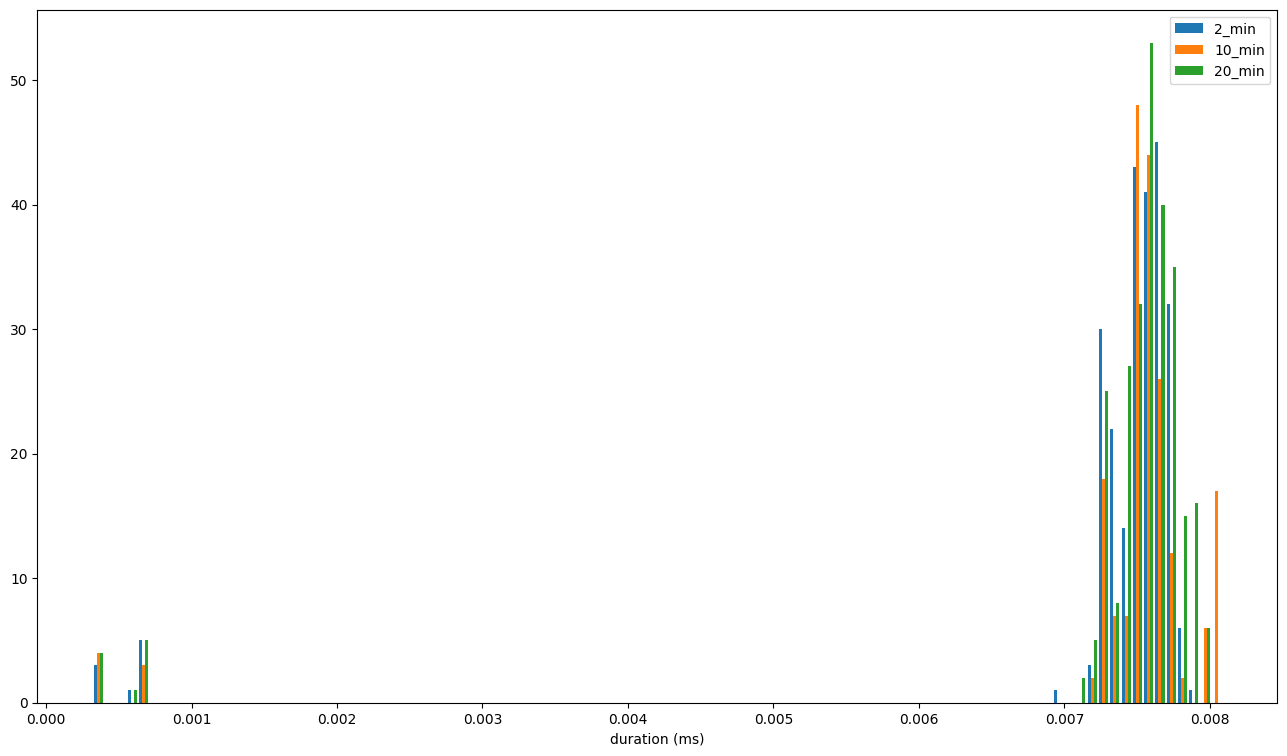

In [14]:
plt.figure(figsize=(16,9))
plt.hist(data, label=experiment_dfs.keys(), bins=100)
plt.legend()
plt.xlabel("duration (ms)")
plt.show()

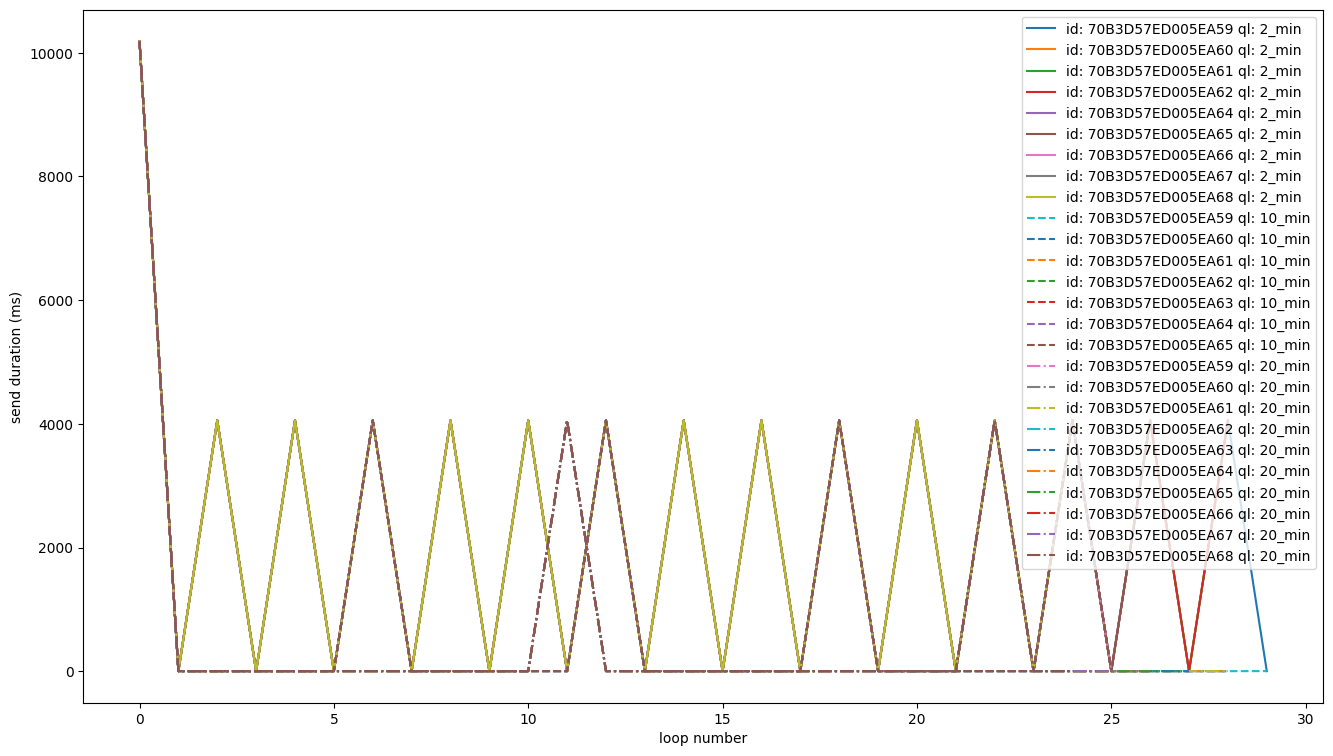

In [15]:
# lets prepare some data for plotting
styles ={
    "2_min": "-",
    "10_min": "--",
    "20_min": "-.",
}
plt.figure(figsize=(16,9))
for k,v in experiment_dfs.items():
    grouper = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
    differences = (grouper.last() - grouper.first())[idx[:,:,"send"]] / np.timedelta64(1, "ms")
    for name, group in differences.groupby("node_id", observed=True):
        #print()
        plt.plot(group[idx[name,:,:]], label=f"id: {name} ql: {k}", linestyle=styles[k], )
plt.legend()
plt.xlabel("loop number")
plt.ylabel("send duration (ms)")
plt.show()

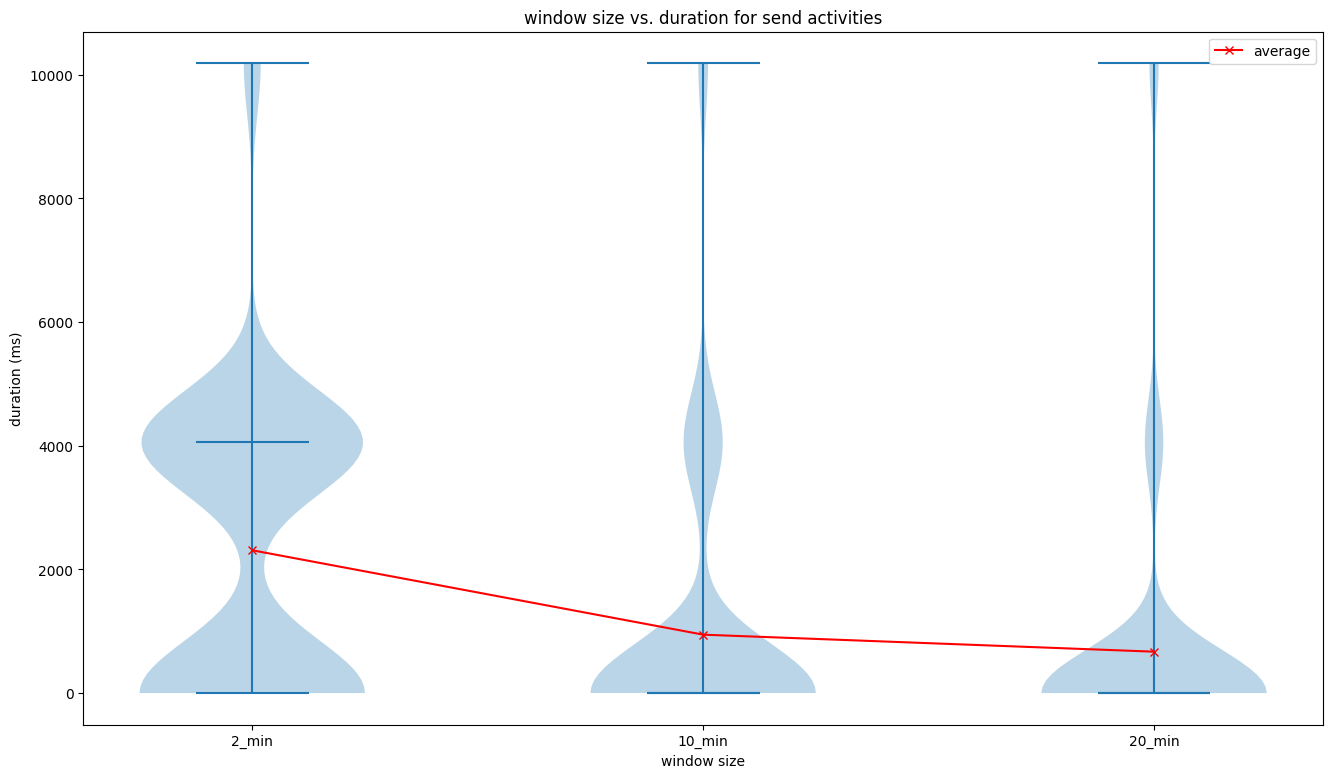

In [9]:
# lets do a box plot of duration on serialization
plt.figure(figsize=(16,9))
plt.violinplot(data, showmedians=True)
plt.plot(np.arange(len(averages)) + 1,averages, "r-x", label="average")

plt.ylabel("duration (ms)")
plt.xlabel("window size")
plt.title("window size vs. duration for send activities")

plt.gca().set_xticks(np.arange(len(averages)) + 1,labels=labels)
plt.legend()
plt.show()

In [10]:
# now figure out the power consumed per activity
# we do this by figuring out what the total power consumed is per node_id,loop_num,activity.
# to find that we need the time difference between each timestamp and the previous one in seconds and then multiply that with the wattage to get power consumed in WattSeconds or joule for that time slice.
# we then sum over the whole activity to get the total count of joules
for k,v in experiment_dfs.items():
    v["timestamp_diff"]  = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"].diff()
    v["joule"] = v["timestamp_diff"].dt.total_seconds() * v["power"]


In [11]:
v.groupby(["node_id", "loop_num", "activity"], observed=True)["joule"].sum()[idx[:,:,"send"]]

node_id           loop_num
70B3D57ED005EA59  0.0         3.207741
                  1.0         0.000669
                  2.0         0.000672
                  3.0         0.000670
                  4.0         0.000671
                                ...   
70B3D57ED005EA68  20.0        0.000627
                  21.0        0.000309
                  22.0        1.485174
                  23.0        0.000631
                  24.0        0.000635
Name: joule, Length: 274, dtype: float64

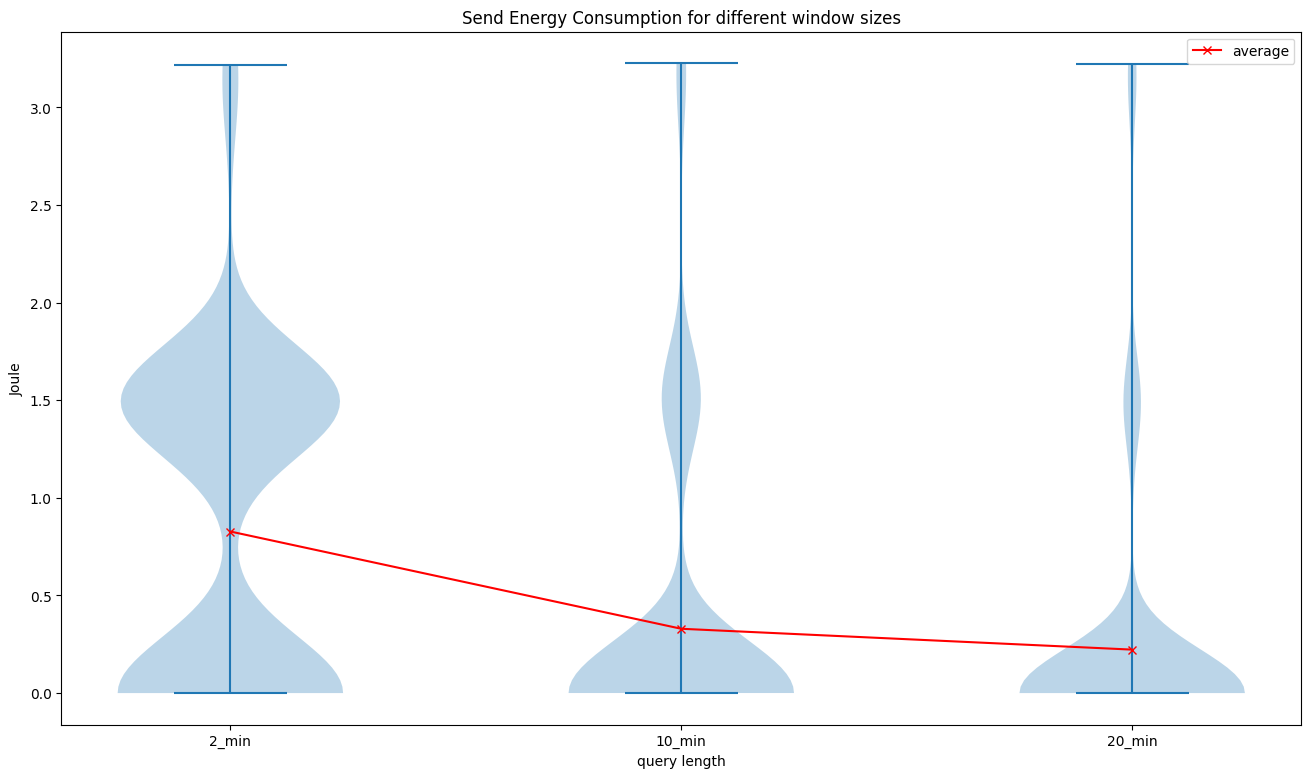

In [18]:
## lets see if we can plot the deserialization energy consumptions for the different queries
plt.figure(figsize=(16,9))
labels = []
averages = []
data = []

for k,v in experiment_dfs.items():
    d = v.groupby(["node_id", "loop_num", "activity"], observed=True)["joule"].sum()[idx[:,:,"send"]]
    data.append(d)
    averages.append(d.mean())
    labels.append(k)

plt.violinplot(data)
plt.plot(np.arange(len(averages)) + 1,averages, "r-x", label="average")
plt.ylabel("Joule")
plt.xlabel("query length")
plt.gca().set_xticks(np.arange(len(averages)) + 1,labels=labels)
plt.title("Send Energy Consumption for different window sizes")
plt.legend()
plt.show()
